$\DeclareMathOperator*{\argmax}{\arg\!\max}$
$\DeclareMathOperator*{\sh}{sh}$
$\DeclareMathOperator*{\ch}{ch}$

# Метрические алгоритмы

## Теоретическое задание

### Задача 1
Может ли в методе $k$ ближайших соседей при $k=4$ получиться лучший результат, чем при $k=3$? Отказы от классификации тоже считать ошибками.

### Решение
Классическое определение метода $k$ ближайших соседей (kNN):
$$ \alpha(u) = \argmax_{y\in Y}\sum\limits_{i=1}^m[y(x_{i,u}) = y]w(i,u) $$
где $x_{i, u}$ — $i$-й сосед в обучающей выборке $X^m = \{(x_1, y_1), ..., (x_m, y_m)\}$ объекта $u$. Номер соседа определяется в порядке возрастания расстояния от $u$ до него:
$$\rho (u, x_{1, u}) \le \rho (u, x_{2, u}) \le ... \le \rho (u, x_{m, u})$$
При этом весовая функция $w(i,u)$ задается так: 
$$ w(i,u) = [i \le k] $$

Таким образом, в классическом kNN класс исследуемого объекта $u$ полагается равным наиболее часто встречаемому классу среди первых $k$ соседей объекта $u$.

Отказ от классификации происходит в случае, если $\argmax$ определен неоднозначно, т.е. есть несколько классов, представленных одинаково часто среди первых $k$ соседей.

__Случай 1. Классификация бинарная__

В случае $k = 3$ отказа от классификации быть не может: классов всего 2, а соседей 3, следовательно (по принципу Дирихле) один из классов встретится дважды. Пусть классы называются $A$ и $B$ и в случае $k = 3$ алгоритм отнес объект $u$ к классу $A$.

При добавлении соседа $x_{4,u}$ ($k=4$) возможны два варианта:
* $x_{4,u}$ также относится к классу $A$. Тогда результат работы классификатора не изменится.
* $x_{4,u}$ относится к классу $B$. Тогда возникнет отказ от классификации, т.к. оба класса будут представлены равным числом соседей.

Таким образом, в случае бинарной классификации в kNN при $k = 4$ __не может__ получиться лучший результат, чем при $k = 3$.

__Случай 2. Классификация не бинарная__

Предположим, что классов всего 3 ($A$, $B$ и $C$) и при $k = 3$ возник отказ от классификации, т.е., например, $y(x_{1,u}) = A$, $y(x_{2,u}) = B$, $y(x_{3,u}) = C$. Предположим также, что объект $u$ должен быть отнесен к классу A.

Тогда, если $y(x_{4,u}) = A$, то при $k = 4$ классификатор отнесет $u$ к классу $A$, давая верный результат.

Таким образом, в случае небинарной классификации в kNN при $k = 4$ __может__ получиться лучший результат, чем при $k = 3$.

## Практическое задание
Сгенерируйте и визуализируйте ряд двумерных обучающих выборок (не менее 3), разделенных на два класса и образующих фигуру "пила" (как в примере). Выборки должны иметь одинаковое количество объектов, но отличаться высотой и шириной зубцов "пилы".

In [16]:
from sklearn import cross_validation, ensemble, grid_search, linear_model, metrics, pipeline, preprocessing
from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial import KDTree
from scipy.special import binom
from itertools import cycle

import random as rndm
import numpy as np
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
# Scatters given sets of points on the plane
def plot_model_data(blue_data, red_data):
    plt.figure(figsize=(10, 10))
    plt.scatter(blue_data[:,0], blue_data[:,1], color="blue", alpha=0.3)
    plt.scatter(red_data[:,0], red_data[:,1], color="red", alpha=0.3)
    plt.show()

In [5]:
# Creates two sets of points, representing red and blue parts of the saw figure
def generate_saw(point_count, width, height):
    points = np.random.rand(point_count, 2)
    subsaw_index = (points[:, 0] / width).astype(int)
    unit = points[:, 0] - subsaw_index * width
    below_index = points[:, 1] < 0.5 - 2.0 * (subsaw_index % 2 - 0.5) * (unit * 2 * height / width - height)
    blue_data = points[below_index, :]
    red_data = points[~below_index, :]
    return blue_data, red_data

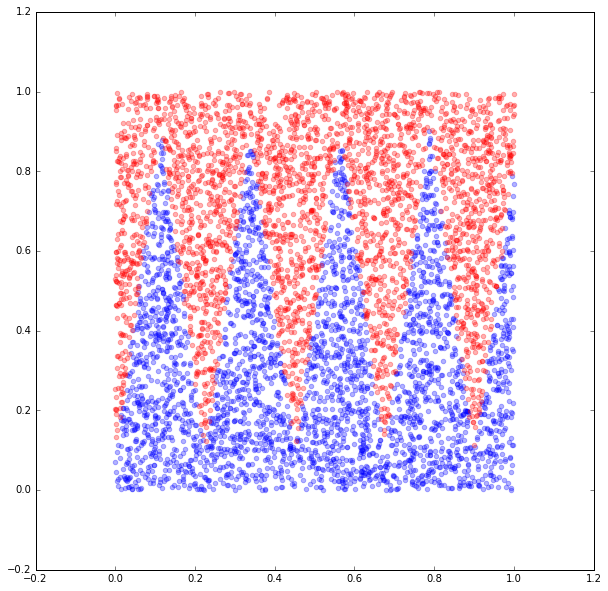

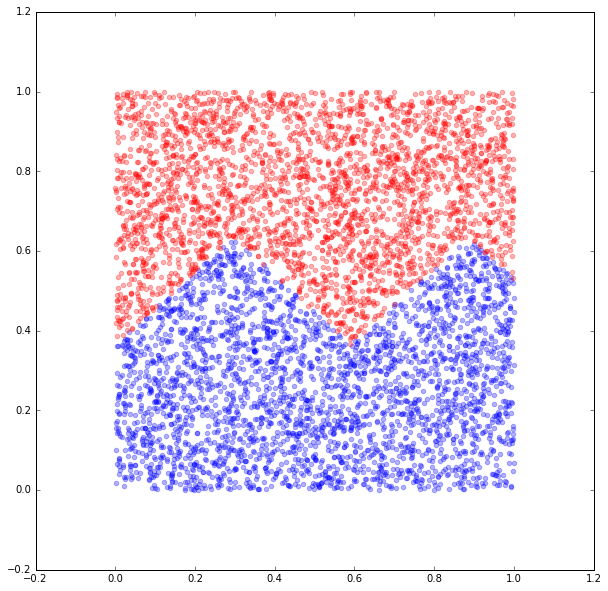

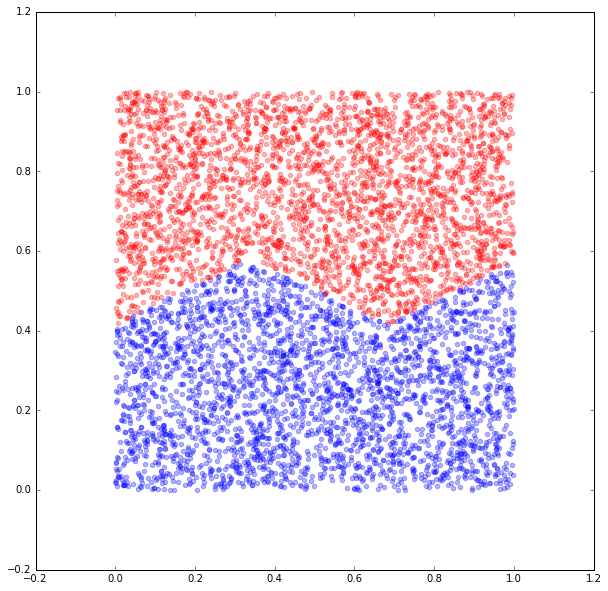

In [6]:
point_count = 6000
saw_count = 3
[widths, heights] = (np.array((np.random.rand(2, saw_count))) + 0.1) / 2
saw_class_pairs = []
for i in xrange(saw_count):
    saw_class_pairs.append(generate_saw(point_count, widths[i], heights[i]))
    plot_model_data(saw_class_pairs[i][0], saw_class_pairs[i][1])

train_x, train_y = [], []
for saw_points_blue, saw_points_red in saw_class_pairs:
    train_x.append( np.concatenate( (saw_points_blue, saw_points_red) ) )
    # blue = True, red = False
    ans_blue = np.repeat ([True], saw_points_blue.shape[0])
    ans_red = np.repeat ([False], saw_points_red.shape[0])
    train_y.append( np.concatenate( (ans_blue , ans_red) ) )

Для каждой выборки:

1) Посчитайте первых 5 профилей компактности.
Профилем компактности выборки $X^m$ называется функция:
$$R(j, X^m) = \frac{1}{m}\sum\limits_{i=1}^m [y(x_i) \ne y(x_{j,x_i})]$$

Чтобы посчитать первых 5 профилей компактности, необходимо для каждого объекта $x_i$ выборки вычислить класс объекта, стоящего $j$-м месте в списке соседей $x_i$-го объекта, т.е. для каждого объекта $x_i$ выборки найти $j$-ую порядковую статистику в списке его соседей.

In [7]:
def kth_neighbor(points, x = 0, k = 1, kdt = None):
    if k == 0:
        # zero-neighbor of x is x
        return x
    if kdt == None:
        kdt = KDTree(points)
    (dists, neighbor_indices) = kdt.query(points[x], k + 1)
    return neighbor_indices[k]

def count_profile(profile_count, train_x, train_y):
    res = 0
    kdt = KDTree(train_x)
    for i in xrange(len(train_x)):
        j = kth_neighbor(train_x, i, profile_count, kdt)
        res += (train_y[i] != train_y[j])
    return 1.0 * res / train_x.shape[0]

profile_count = 5
profiles = [[] for i in xrange(saw_count)]

for saw_index in xrange(saw_count):
    print 'Saw #' + str(saw_index)
    for profile_index in xrange(profile_count):
        profile = count_profile(profile_index + 1, train_x[saw_index], train_y[saw_index])
        print '\tProfile ' + str(profile_index) + ': ', profile
        profiles[saw_index].append( profile )

Saw #0
	Profile 0:  0.0278333333333
	Profile 1:  0.0408333333333
	Profile 2:  0.0596666666667
	Profile 3:  0.0656666666667
	Profile 4:  0.0676666666667
Saw #1
	Profile 0:  0.00516666666667
	Profile 1:  0.00816666666667
	Profile 2:  0.0106666666667
	Profile 3:  0.0123333333333
	Profile 4:  0.0138333333333
Saw #2
	Profile 0:  0.00366666666667
	Profile 1:  0.00483333333333
	Profile 2:  0.00733333333333
	Profile 3:  0.0125
	Profile 4:  0.0103333333333


2) Посчитайте CCV для алгоритма одного ближайшего соседа и длин контрольной выборки от 1 до 5.

Выборка $X^L$ разбивается всевозможными $N=C_L^k$ способами на две непересекающиеся подвыборки: $X^L=X_n^m \cup X_n^k$, где $X_n^m$ — обучающая подвыборка длины $m$, $X_n^k$ — контрольная подвыборка длины $k=L-m$, $n=1,...,N$ — номер разбиения.

Воспользуемся формулой для вычисления CCV для алгоритма 1NN через профиль компактности:
$$CCV(X^L) = \sum\limits_{j=1}^k R(j, X^L)\Gamma (j)$$
где $\Gamma (j) = \frac {C_{L-1-j}^{m-1}} {C_{L-1}^{m}}$.

In [8]:
ccv_sample = [[] for i in xrange(saw_count)]
for saw_index in xrange(saw_count):
    print 'Saw #' + str(saw_index)
    test_sample_size_bounds = (1, 6)
    L = len(train_x[saw_index])
    for k in xrange(test_sample_size_bounds[0], test_sample_size_bounds[1]):
        print '\tTest sample size: ' + str(k)
        ccv_part = 0
        m = L - k
        for j in xrange(1, k + 1):
            R = count_profile(j, train_x[saw_index], train_y[saw_index])
            ccv_part += 1.0 * R * binom(L-1-j, m-1) / binom(L-1, m)
        ccv_part = 1 - ccv_part
        print '\t\tCCV = ' + str(ccv_part)
        ccv_sample[saw_index].append(ccv_part)

Saw #0
	Test sample size: 1
		CCV = 0.972166666667
	Test sample size: 2
		CCV = 0.972164499639
	Test sample size: 3
		CCV = 0.972162331564
	Test sample size: 4
		CCV = 0.972160162443
	Test sample size: 5
		CCV = 0.972157992274
Saw #1
	Test sample size: 1
		CCV = 0.994833333333
	Test sample size: 2
		CCV = 0.99483283325
	Test sample size: 3
		CCV = 0.994832333028
	Test sample size: 4
		CCV = 0.994831832666
	Test sample size: 5
		CCV = 0.994831332166
Saw #2
	Test sample size: 1
		CCV = 0.996333333333
	Test sample size: 2
		CCV = 0.996333138856
	Test sample size: 3
		CCV = 0.996332944241
	Test sample size: 4
		CCV = 0.996332749486
	Test sample size: 5
		CCV = 0.996332554592


3) Посчитайте функционал скользящего контроля при разбиении методом KFold. Постройте график зависимости величины профиля компактности $P$ от номера $m$.

In [9]:
for saw_index in xrange(saw_count):
    print 'Saw #' + str(saw_index)
    cv_gen = cross_validation.KFold(len(train_x[saw_index]), n_folds = 50, shuffle = True)
    classifier = KNeighborsClassifier(n_neighbors=1)
    cv_score = cross_validation.cross_val_score(classifier, train_x[saw_index], train_y[saw_index], cv = cv_gen)
    print '\t' + str(average(cv_score))

Saw #0
	0.971166666667
Saw #1
	0.995
Saw #2
	0.996333333333


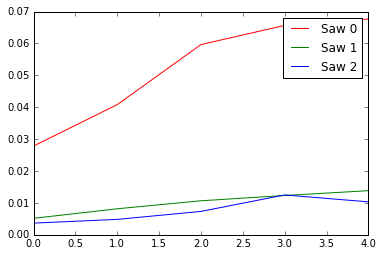

In [10]:
cycol = cycle('rgbcmk').next
for saw_index in xrange(saw_count):
    plt.plot( range(len(profiles[saw_index])), profiles[saw_index], cycol() + '-', label = 'Saw ' + str(saw_index) )
plt.legend()
plt.show()

4) Постройте график зависимости величины CCV для алгоритма одного ближайшего соседа от длины контрольной выборки.

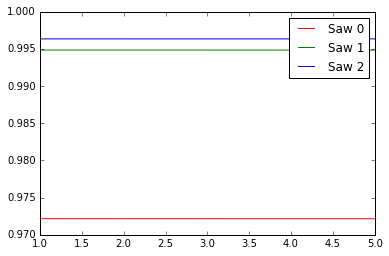

In [61]:
cycol = cycle('rgbcmk').next
sample_size_range = range(test_sample_size_bounds[0], test_sample_size_bounds[1])

for saw_index in xrange(saw_count):
    plt.plot( sample_size_range, ccv_sample[saw_index], cycol() + '-', label = 'Saw ' + str(saw_index) )
plt.legend()
plt.show()

5) Постройте график зависимости величины CCV от количества рассматриваемых соседей при длине контрольной выборки равной 5.

In [12]:
test_sample_size = 5
for saw_index in xrange(saw_count):
    print 'Saw #' + str(saw_index)
    cv_gen = cross_validation.LeavePOut(n = len(train_x[saw_index]), p = test_sample_size)
    print len(cv_gen)

Saw #0
64692062985001200
Saw #1
64692062985001200
Saw #2
64692062985001200


Вычисление CCV на основе исходной выборки из point_count = 6000 точек включает в себя перебор всех возможных контрольных выборок длины 5, коих $C_{6000}^5 = 64692062985001200$. Даже если бы классификация одного объекта проходила за $O(1)$ (что неверно), дожидаться ответа при доступных мне вычислительных ресурсах (и грубых оценках) пришлось бы около 2-х лет. Ввиду отсутствия возможности ждать столь продолжительное время, принято решение существенно сократить исходную выборку для выполнения этого пункта задания.

In [56]:
point_count_mini = 30
train_x_mini = [[] for i in xrange(saw_count)]
train_y_mini = [[] for i in xrange(saw_count)]
for saw_index in xrange(saw_count):
    train_x_mini_indices = rndm.sample(xrange(len(train_x[saw_index])), point_count_mini)
    train_x_mini[saw_index] = np.array([train_x[saw_index][i] for i in train_x_mini_indices])
    train_y_mini[saw_index] = [train_y[saw_index][i] for i in train_x_mini_indices]

In [57]:
def ccv_of_neighbors(sample_x, sample_y, test_sample_size, neighbors_count = 1):
    cv_gen = cross_validation.LeavePOut(n = len(sample_x), p = test_sample_size)
    classifier = KNeighborsClassifier(n_neighbors = neighbors_count)
    cv_score = cross_validation.cross_val_score(classifier, sample_x, sample_y, cv = cv_gen)
    return average(cv_score)
    
test_sample_size = 5
max_neighbors_count = point_count_mini - test_sample_size
ccv_of_neighbors_res = [[] for i in xrange(saw_count)]
for saw_index in xrange(saw_count):
    print 'Saw #' + str(saw_index)
    for i in xrange(1, max_neighbors_count + 1):
        print '\tNeighbors: ' + str(i)
        ccv_val = ccv_of_neighbors(train_x_mini[saw_index], train_y_mini[saw_index], test_sample_size, i)
        ccv_of_neighbors_res[saw_index].append(ccv_val)
        print '\t\tCCV = ' + str(ccv_val)

Saw #0
	Neighbors: 1
		CCV = 0.840097960788
	Neighbors: 2
		CCV = 0.782851248368
	Neighbors: 3
		CCV = 0.809114002217
	Neighbors: 4
		CCV = 0.837042650836
	Neighbors: 5
		CCV = 0.856696560145
	Neighbors: 6
		CCV = 0.864773413049
	Neighbors: 7
		CCV = 0.880702566909
	Neighbors: 8
		CCV = 0.880470997712
	Neighbors: 9
		CCV = 0.870681936199
	Neighbors: 10
		CCV = 0.857206012378
	Neighbors: 11
		CCV = 0.844149720012
	Neighbors: 12
		CCV = 0.834502406916
	Neighbors: 13
		CCV = 0.833991551233
	Neighbors: 14
		CCV = 0.838044713907
	Neighbors: 15
		CCV = 0.826630457665
	Neighbors: 16
		CCV = 0.829472443266
	Neighbors: 17
		CCV = 0.795873857943
	Neighbors: 18
		CCV = 0.810224130914
	Neighbors: 19
		CCV = 0.791986302331
	Neighbors: 20
		CCV = 0.786176020659
	Neighbors: 21
		CCV = 0.752932508105
	Neighbors: 22
		CCV = 0.680844315327
	Neighbors: 23
		CCV = 0.59015339705
	Neighbors: 24
		CCV = 0.458766648422
	Neighbors: 25
		CCV = 0.325670498084
Saw #1
	Neighbors: 1
		CCV = 0.911638808191
	Neighbor

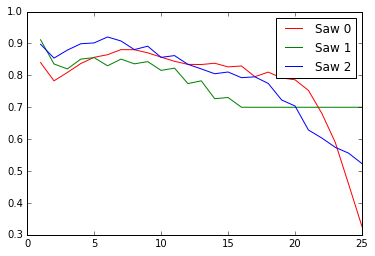

In [58]:
cycol = cycle('rgbcmk').next
for saw_index in xrange(saw_count):
    lab = 'Saw ' + str(saw_index)
    plt.plot( range(1, max_neighbors_count + 1), ccv_of_neighbors_res[saw_index], cycol() + '-', label = lab )
plt.legend()
plt.show()

# Линейные алгоритмы

## Теоретическое задание

### Задача 1
Являются ли ядрами:  
a) $K(x,y) = \exp(2\langle x,y\rangle)+\langle y+x,3y+x\rangle$;  
b) $K(x,y) = \ch(\langle x,y\rangle)$+$3\sh(\langle x,y\rangle)$?

### Решение
Ядром называется функция $K:X\times X\rightarrow \mathbb R$, если она представима в виде $K(x, x^\prime) = \langle \psi(x) , \psi(x^\prime)\rangle$ при некотором отображении $\psi: X\rightarrow H$, где $H$ — пространство со скалярным произведением.

Теорема Мерсера: функция $K(x, x^\prime)$ является ядром тогда и только тогда, когда
- она симметрична: $\forall x,x^\prime \in X: K(x, x^\prime) = K(x^\prime, x)$ и
- неотрицательно определена: $\forall g:X\rightarrow \mathbb R:\ \int\limits_X\int\limits_X K(x, x^\prime) g(x)g(x^\prime)dxdx^\prime \ge 0$.

a) Положим $X=\mathbb R$, $x = 0$, $x^\prime = 1$. Тогда $\forall y,y^\prime\in X: \langle y,y^\prime\rangle = y\cdot y^\prime$.  
$K(x,x^\prime) = K(0, 1) = \exp(2\cdot \langle 0, 1\rangle) + \langle 1, 3\rangle = 1 + 3 = 4$  
$K(x^\prime,x) = K(1, 0) = \exp(2\cdot \langle 1, 0\rangle) + \langle 1, 1\rangle = 1 + 1 = 2$  
$K(0, 1) \ne K(1, 0)$, т.е. функция не симметрична. А тогда, по теореме Мерсера, она __не является ядром__.

б) Воспользуемся конструктивными способами построения ядер:  
_Утв. 1._ Произвольное скалярное произведение $\langle x, y\rangle$ является ядром.  
_Утв. 2._ Линейная комбинация ядер $K_1(x,y)$, $K_2(x,y)$ с неотрицательными коэффициентами $\alpha_1$, $\alpha_2$ является ядром: $K(x,y) = \alpha_1 K_1(x,y) + \alpha_2 K_2(x,y)$.  
_Утв. 3._ Композиция произвольного ядра $K_0$ и произвольной функции $f: \mathbb R \rightarrow \mathbb R$, представимой в виде сходящегося степенного ряда с неотрицательными коэффициентами, является ядром: $K(x,y) = f(K_0(x,y))$.

$\langle x,y\rangle$ — ядро по утв. 1.  
$\sh \langle x,y\rangle$, $\ch \langle x,y\rangle$ — ядра по утв. 3, т.к. $\sh(x) = \frac {x^1}{1!} + \frac {x^3}{3!} + \frac {x^5}{5!} + ... = \sum\limits_{k=0}^\infty \frac{x^{2k+1}}{(2k+1)!}$ и $\ch(x) = \frac {x^0}{0!} + \frac {x^2}{2!} + \frac {x^4}{4!} + ... = \sum\limits_{k=0}^\infty \frac{x^{2k}}{(2k)!}$ — сходящиеся степенные ряды с неотрицательными коэффициентами.  
$\ch \langle x,y\rangle + 3\sh \langle x,y\rangle$ — ядра по утв. 2, как линейная комбинация ядер с неотрицательными коэффициентами $\alpha_1 = 1$, $\alpha_2 = 3$.

Таким образом, исходная функция __является ядром__.

### Задача 2
Для какого алгоритма классификации функционал аппроксимированного риска будет принимать большее значение на обучающей выборке: для построенного с регуляризацией или без нее? Почему?

### Решение
...